In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import altair as alt

from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/2020/P02_Pokemon-generator/data/pokemon_imgs.pkl', "rb") as f:
    pokemon = pickle.load(f)

In [0]:
pokemon.shape

In [0]:
#random_pokemon = np.random.choice(pokemon.shape, 5, replace = False)
pokemon_rn = np.mean(pokemon, axis = 0)
pokemon_rn.shape

In [0]:
plt.imshow(pokemon_rn)

In [0]:
pic_pca = PCA(n_components = 2)
Z = pic_pca.fit_transform(pokemon.reshape(890, -1))

In [106]:
Z.shape

(890, 2)

In [0]:
def img_tiling(idx, size = 1000):
    """
    Plots a 5x5 tiling of faces.
    
    Parameters:
    -----------
    idx: the indexes of the faces to be plotted. This should be a 5x5 matrix, where each 
         elements is an index corresponding to the closest face of that grid point.
     
    size: the desired size of the plot;
    """
    
    # Just making sure the indexes are int
    idx = np.array(idx, dtype="int32")
    
    #Creating the image with the desired size
    plt.figure(figsize=(size, size))
    
    #Ploting the 5x5 tiling
    for i,x in enumerate(np.linspace(np.min(Z[:,0]),np.max(Z[:,0]),5)):
        for j,y in enumerate(np.linspace(np.min(Z[:,1]),np.max(Z[:,1]),5)):
            face = np.reshape(pokemon[idx[i,j],:,:,0:4], (475,475,-1)) # Obtain the closest face
            plt.imshow(face, extent=(i*475,(i+1)*475,j*475,(j+1)*475)) # Plot the closest face
   
    plt.xlim((0,475*5))
    plt.ylim((0,475*5))
    plt.xticks([])
    plt.yticks([])

In [122]:
z_2pc = Z[:,0:2]
z_df = pd.DataFrame(Z[:,0:2], columns = ['X1', 'X2'])
projected = alt.Chart(z_df).mark_circle(color = 'black', opacity = 0.4).encode(
                alt.X('X1:Q'),
                alt.Y('X2:Q')
            ).properties(
                title = 'First and Second Component transformations (Compressed Data)'
            )

projected

alt.Chart(...)

In [0]:
max_values = np.max(z_2pc, axis = 0)
min_values = np.min(z_2pc, axis = 0)

n_steps = 5
x1_sequence = np.linspace(min_values[0], max_values[0], n_steps)
x2_sequence = np.linspace(min_values[1], max_values[1], n_steps)

comb_array = np.stack(np.meshgrid(x1_sequence, x2_sequence), -1)
combinations = comb_array.reshape((-1, 1, 2))  
comb_points = pd.DataFrame(combinations.reshape((-1, 2)), columns = ['X1', 'X2'])

distance_point = np.sum(((z_2pc - combinations)**2), axis = 2)
closest_points = np.argmin(distance_point, axis = 1)

#new_points = pic_pca.transform(Z)
a1 = pic_pca.components_
new_points = z_2pc@a1
new_points = new_points.reshape((-1, 475, 475, 4))

plt.imshow(new_points[0,:,:,:])

In [70]:
closets_df = pd.DataFrame(z_2pc[closest_points,:], columns = ['X1', 'X2'])

chosen_points = alt.Chart(comb_points).mark_circle(color = 'red').encode(
                alt.X('X1:Q'),
                alt.Y('X2:Q')
            )
closests = alt.Chart(closets_df).mark_circle(color = 'cyan').encode(
                alt.X('X1:Q'),
                alt.Y('X2:Q')
            )


projected + chosen_points + closests

alt.LayerChart(...)

array([[357, 575, 188, 612, 475],
       [817, 624, 629,  23, 316],
       [282, 585, 667,   8, 365],
       [ 73, 248, 888, 556, 516],
       [263, 373, 533, 139,   0]])

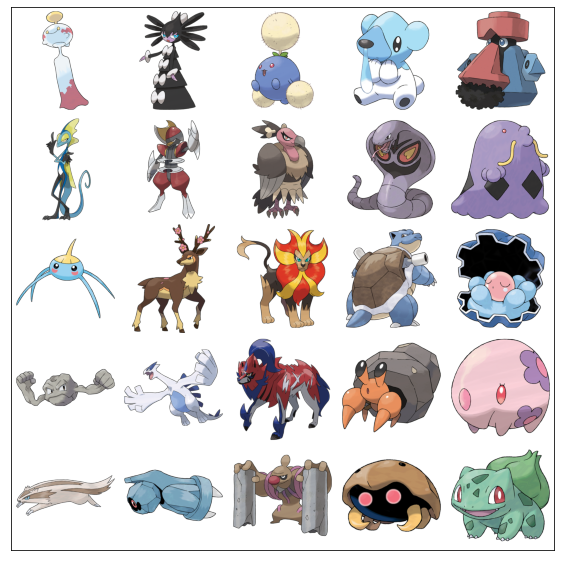

In [71]:
img_tiling(closest_points.reshape((5,5))[::-1].T, size = 10)

closest_points.reshape((5,5))


In [25]:
closest_points.reshape((5,5))

array([[570, 337, 343, 440, 395],
       [265, 613, 241, 427, 418],
       [  2, 533,  91, 782, 573],
       [368, 769, 858, 724, 593],
       [225, 263, 332, 839, 810]])

In [0]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [0]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



In [75]:
x_train = pokemon

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
#x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 1

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
cvae = Model(inputs, outputs, name='vae')

# build model
models = (encoder, decoder)

# VAE loss = mse_loss or xent_loss + kl_loss
# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                          K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
cvae_loss = K.mean(reconstruction_loss + kl_loss)
cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 475, 475, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 238, 238, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 119, 119, 64) 18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 906304)       0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [80]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
cvae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
#         validation_data=(x_test, None),
        callbacks=[early_stop],
        verbose=1)
#cvae.save_weights('/content/gdrive/My Drive/2020/P02_Pokemon-generator/vae_2L')
models = (cvae.get_layer('encoder'),
          cvae.get_layer('decoder'))

ResourceExhaustedError: ignored